# 👖 オートエンコーダ - Fashion MNIST

このノートブックでは，Fashion MNISTデータセットに対して，オートエンコーダモデルを自分で構築・学習する手順を説明します．

In [1]:
!pip install japanize_matplotlib | tail -n 1
!pip install torchinfo | tail -n 1

In [2]:
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
import japanize_matplotlib
import torchvision
import torch
import torchinfo
import random
from torch import nn
from torch.utils.data import DataLoader
import sys
print(sys.version)
print(torch.__version__)

3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
2.5.1+cu121


In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available():
        # MPSを使用する場合の設定
        torch.backends.mps.deterministic = True
    elif torch.cuda.is_available():
        # CUDAが利用可能な場合
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


# シード値を設定
set_seed(123)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(device)

cuda


## 0. パラメータ

In [4]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 100
BUFFER_SIZE = 1000
VALIDATION_SPLIT = 0.2
EMBEDDING_DIM = 2
EPOCHS = 3

## 1. データ準備

In [5]:
# CIFAR10のデータセットを読み込み
transform = torchvision.transforms.Compose([
    torchvision.transforms.Pad(padding=2),  # 2ピクセルのパディングを追加
    torchvision.transforms.ToTensor(),
])
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)


CLASSES = np.array([
        "Tシャツ／トップス",
        "ズボン",
        "プルオーバー", # 頭から被って着る服
        "ドレス",
        "コート",
        "サンダル",
        "シャツ",
        "スニーカー",
        "バッグ",
        "アンクルブーツ", # かかとが隠れる丈のブーツ
        ])

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.8MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 171kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:04<00:00, 928kB/s] 


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 6.75MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Pad(padding=2, fill=0, padding_mode=constant)
               ToTensor()
           )


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

(1, 32, 32)


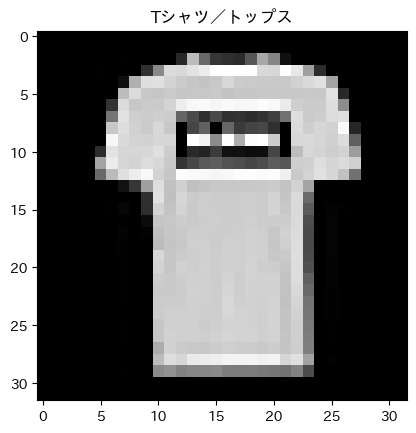

In [22]:
print(trainset)
# データ確認
display(trainset[0][0])
# サイズ確認
print(np.array(trainset[0][0]).shape)
# データの可視化
plt.imshow(trainset[1][0].permute(1,2,0), cmap='gray')
plt.title(CLASSES[trainset[1][1]])
plt.show()

## 2. オートエンコーダの実装

In [7]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, kernel_size=(3, 3), out_channels=32, padding=1, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, kernel_size=(3, 3), out_channels=64, padding=1, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, kernel_size=(3, 3), out_channels=128, padding=1, stride=2)

        self.flatten = nn.Flatten()

        self.fc = nn.Linear(in_features=4 * 4 * 128, out_features=EMBEDDING_DIM)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(in_features=EMBEDDING_DIM, out_features=4 * 4 * 128)
        self.deconv1 = nn.ConvTranspose2d(in_channels=128, kernel_size=(3, 3), out_channels=128, padding=1, output_padding=1, stride=2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, kernel_size=(3, 3), out_channels=64, padding=1, output_padding=1, stride=2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, kernel_size=(3, 3), out_channels=32, padding=1, output_padding=1, stride=2)
        self.conv1 = nn.Conv2d(in_channels=32, kernel_size=(3, 3), out_channels=1, padding=1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 128, 4, 4)
        x = self.deconv1(x)
        x = self.relu(x)
        x = self.deconv2(x)
        x = self.relu(x)
        x = self.deconv3(x)
        x = self.relu(x)
        x = self.conv1(x)
        x = self.sigmoid(x)
        return x


class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [8]:
torchinfo.summary(Encoder().to(device), input_size=(1, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
Encoder                                  [1, 2]                    --
├─Conv2d: 1-1                            [1, 32, 16, 16]           320
├─ReLU: 1-2                              [1, 32, 16, 16]           --
├─Conv2d: 1-3                            [1, 64, 8, 8]             18,496
├─ReLU: 1-4                              [1, 64, 8, 8]             --
├─Conv2d: 1-5                            [1, 128, 4, 4]            73,856
├─ReLU: 1-6                              [1, 128, 4, 4]            --
├─Flatten: 1-7                           [1, 2048]                 --
├─Linear: 1-8                            [1, 2]                    4,098
Total params: 96,770
Trainable params: 96,770
Non-trainable params: 0
Total mult-adds (M): 2.45
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.39
Estimated Total Size (MB): 0.51

In [9]:
torchinfo.summary(Decoder().to(device), input_size=(1, EMBEDDING_DIM))

Layer (type:depth-idx)                   Output Shape              Param #
Decoder                                  [1, 1, 32, 32]            --
├─Linear: 1-1                            [1, 2048]                 6,144
├─ConvTranspose2d: 1-2                   [1, 128, 8, 8]            147,584
├─ReLU: 1-3                              [1, 128, 8, 8]            --
├─ConvTranspose2d: 1-4                   [1, 64, 16, 16]           73,792
├─ReLU: 1-5                              [1, 64, 16, 16]           --
├─ConvTranspose2d: 1-6                   [1, 32, 32, 32]           18,464
├─ReLU: 1-7                              [1, 32, 32, 32]           --
├─Conv2d: 1-8                            [1, 1, 32, 32]            289
├─Sigmoid: 1-9                           [1, 1, 32, 32]            --
Total params: 246,273
Trainable params: 246,273
Non-trainable params: 0
Total mult-adds (M): 47.55
Input size (MB): 0.00
Forward/backward pass size (MB): 0.48
Params size (MB): 0.99
Estimated Total Size (MB):

In [10]:
autoencoder = AutoEncoder()
autoencoder.eval()
torchinfo.summary(autoencoder, input_size=(1, 1, 32, 32), verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 1, 32, 32]            --
├─Encoder: 1-1                           [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 32, 16, 16]           320
│    └─ReLU: 2-2                         [1, 32, 16, 16]           --
│    └─Conv2d: 2-3                       [1, 64, 8, 8]             18,496
│    └─ReLU: 2-4                         [1, 64, 8, 8]             --
│    └─Conv2d: 2-5                       [1, 128, 4, 4]            73,856
│    └─ReLU: 2-6                         [1, 128, 4, 4]            --
│    └─Flatten: 2-7                      [1, 2048]                 --
│    └─Linear: 2-8                       [1, 2]                    4,098
├─Decoder: 1-2                           [1, 1, 32, 32]            --
│    └─Linear: 2-9                       [1, 2048]                 6,144
│    └─ConvTranspose2d: 2-10             [1, 128, 8, 8]            147

### 参考：転置畳み込みの挙動について

転置畳み込みは，通常，その前の層で行われた畳み込みに入力された「入力テンソル」と同じ次元を持つテンソルを得ることが狙いの模様．

そのため，パラメータは注目する通常畳み込みに与えたパラメータを引き継ぐ形で設定する．

ただし，必ずしもこれらのパラメータによって次元の復元ができるとは限らないので，その都度output_paddingによっての調整が必要になる．


転置畳み込みの行サイズ(列サイズ)の計算は次の通り：

出力サイズ = (入力サイズ - 1) * ストライドサイズ(stride) - 2 * パディングサイズ(padding) + カーネルサイズ(kerner_size) + 微調整パディング(output_padding)

以上のことを理解するために，右にテストコードを配置した．
パラメータを調整し，手計算しながらConvTranspose2dの挙動を理解されたい場合はこちらを参照．

In [11]:
# 入力テンソルを定義（バッチサイズ=1、チャンネル数=1、高さ=size、幅=size）
size = 3
h, w = (size, size)
input_tensor = torch.arange(1, h*w + 1).float().reshape(h, w).unsqueeze(0).unsqueeze(0)


print("入力テンソル：")
print(input_tensor.shape)
print(input_tensor)

# ConvTranspose2d のパラメータを設定
in_channels = 1
out_channels = 1
kernel_size = 2
stride = 2 # アップサンプリング倍率（通常，畳み込みで使ったストライドを設定）
padding = 0 # クロップする際のパディング（通常，畳み込みで使ったパディングを設定）
output_padding = 0 # 得たい出力サイズを計算する際のパディング調整分
bias = False

# 畳み込みカーネルを手動で設定（畳み込みの手計算がしやすいように、すべての値を1にする）
conv_transpose = nn.ConvTranspose2d(
    in_channels, out_channels, kernel_size=kernel_size,
    stride=stride, padding=padding, output_padding=output_padding,
    bias=bias
)

# カーネルの重みを手動で設定
with torch.no_grad():
    conv_transpose.weight.fill_(1.0)

# 出力を計算
output_tensor = conv_transpose(input_tensor)

print("\n出力テンソル：")
print(output_tensor.shape)
print(output_tensor)

入力テンソル：
torch.Size([1, 1, 3, 3])
tensor([[[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]])

出力テンソル：
torch.Size([1, 1, 6, 6])
tensor([[[[1., 1., 2., 2., 3., 3.],
          [1., 1., 2., 2., 3., 3.],
          [4., 4., 5., 5., 6., 6.],
          [4., 4., 5., 5., 6., 6.],
          [7., 7., 8., 8., 9., 9.],
          [7., 7., 8., 8., 9., 9.]]]], grad_fn=<ConvolutionBackward0>)


## 3. オートエンコーダの訓練

In [12]:
opt = torch.optim.Adam(autoencoder.parameters())
criterion = nn.BCELoss()

In [13]:
autoencoder = autoencoder.to(device)
autoencoder.train()
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, _ = data
        inputs = inputs.to(device)
        opt.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, inputs)  # 元の入力と出力を比較してロスを計算
        loss.backward() # backpropagation
        opt.step() # モデルのパラメータ更新

        running_loss += loss.item() # 誤差の値を加算

    # epoch終了時点での誤算の平均値
    print(f'epoch {epoch + 1} loss: {running_loss / len(trainset):.4f}')

epoch 1 loss: 0.0029
epoch 2 loss: 0.0026
epoch 3 loss: 0.0025


## 4. 学習したオートエンコーダによるデータ再構築

In [14]:
n_to_predict = 5000
autoencoder.eval()
test_data = [testset[i][0] for i in range(n_to_predict)]
test_labels = [testset[i][1] for i in range(n_to_predict)]
test_data = torch.stack(test_data)
print(test_data.shape)

embeddings = autoencoder.encoder(test_data.to(device)).cpu().detach().numpy()
embeddings.shape

torch.Size([5000, 1, 32, 32])


(5000, 2)

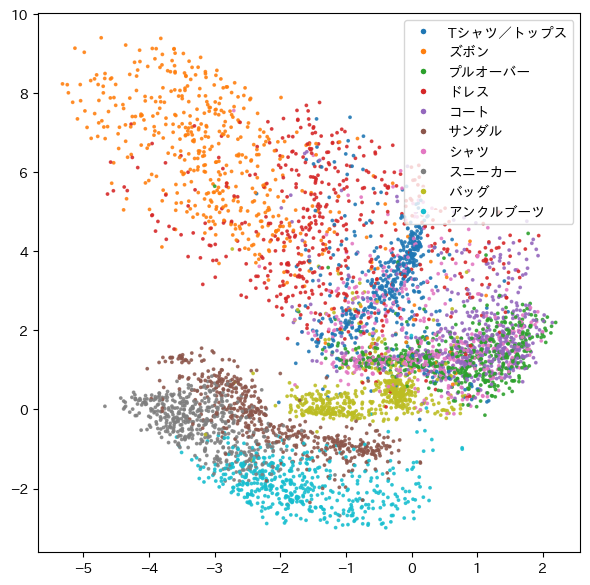

In [15]:
figsize = 7
plt.figure(figsize=(figsize, figsize))

scatter = plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=test_labels,
    cmap="tab10",
    alpha=0.8,
    s=3,
)

# 凡例を追加
handles = [plt.Line2D([0], [0], marker='o', color='w', label=CLASSES[i],
                      markerfacecolor=plt.cm.tab10(i / len(CLASSES)), markersize=5)
           for i in range(len(CLASSES))]
plt.legend(handles=handles)

plt.show()

## 6. デコーダを用いた生成

In [16]:
# 既存の埋め込みの各次元から値の上限・下限を得る
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# 潜在空間の点を一様分布でサンプリングする
grid_width, grid_height = (6, 3)
sample = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, EMBEDDING_DIM)
)

In [17]:
# サンプルされた点をデコードする．
reconstructions = autoencoder.decoder(torch.tensor(sample).float().to(device))

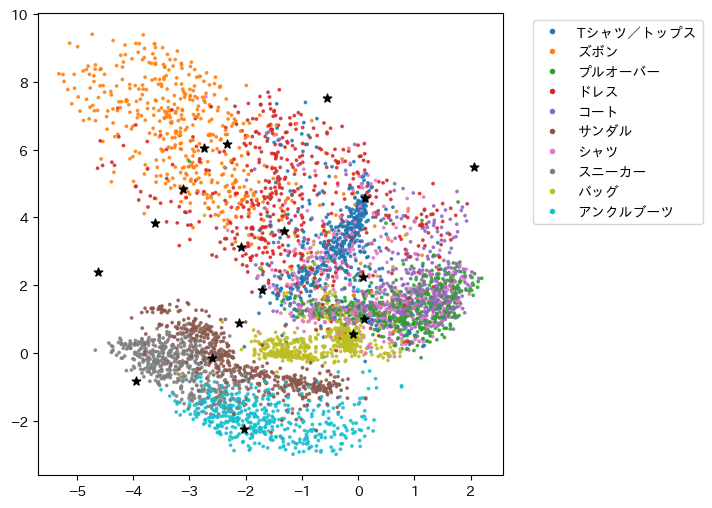

In [18]:
# デコード（生成）されたプロットを描く
figsize = 6
plt.figure(figsize=(figsize, figsize))

scatter = plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=test_labels,
    cmap="tab10",
    alpha=0.8,
    s=3,
)

# 凡例を追加
handles = [plt.Line2D([0], [0], marker='o', color='w', label=CLASSES[i],
                      markerfacecolor=plt.cm.tab10(i / len(CLASSES)), markersize=5)
           for i in range(len(CLASSES))]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), fontsize=10)

plt.scatter(sample[:, 0], sample[:, 1], c='black', marker='*', alpha=1, s=40)
plt.show()

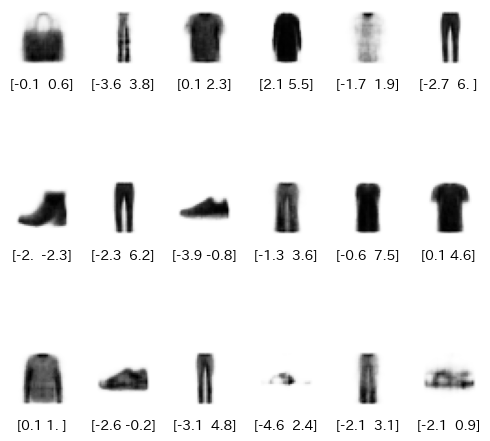

In [19]:
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i+1)
    ax.set_axis_off()
    ax.text(0.5, -0.35, str(np.round(sample[i, :], 1)), fontsize=10, ha="center", transform=ax.transAxes)
    ax.imshow(reconstructions[i, :, :].permute(1, 2, 0).cpu().detach().numpy(), cmap="Greys")

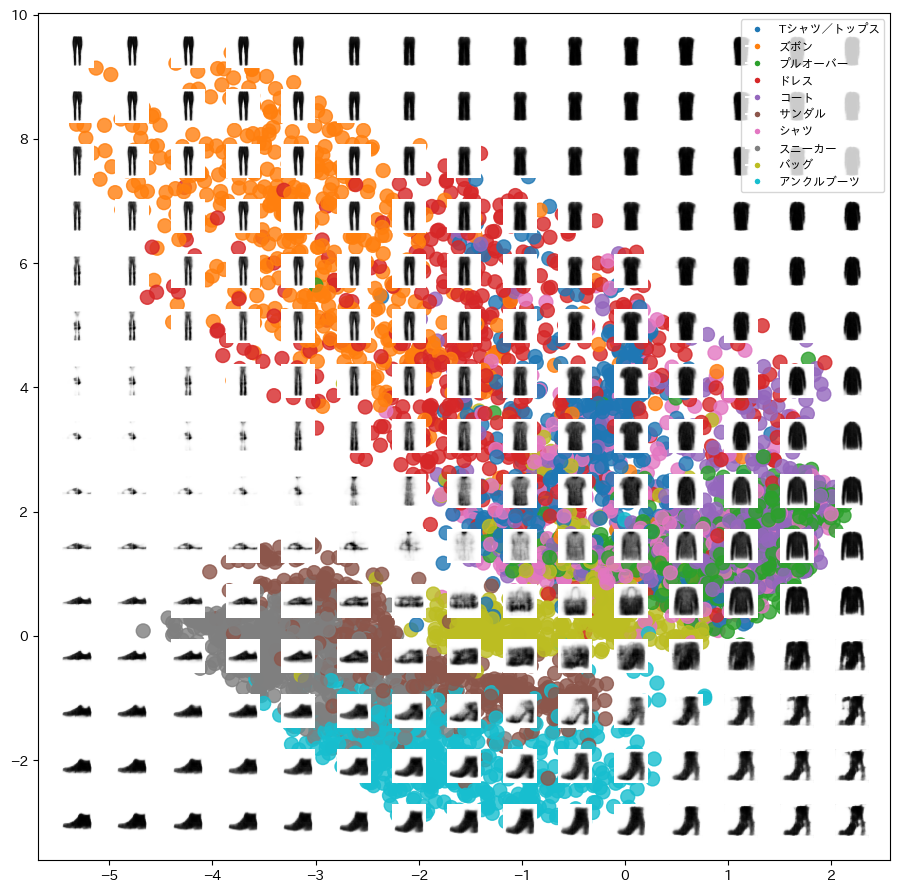

In [21]:
# 必要なライブラリをインポート
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# 図のサイズとグリッドサイズを設定
figsize = 11
grid_size = 15

# 埋め込みをラベル（衣類の種類）で色付けしてプロット
plt.figure(figsize=(figsize, figsize))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="tab10",
    c=test_labels,
    alpha=0.8,
    s=100,
)

# 凡例を追加
handles = [plt.Line2D([0], [0], marker='o', color='w', label=CLASSES[i],
                      markerfacecolor=plt.cm.tab10(i / len(CLASSES)), markersize=5)
           for i in range(len(CLASSES))]
plt.legend(handles=handles,loc='best', fontsize=8.5)


# グリッドを作成
x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(min(embeddings[:, 1]), max(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

# グリッド上の点をデコーダーに通して再構成
reconstructions = autoencoder.decoder(torch.tensor(grid).float().to(device))

# 再構成画像をプロットに重ねて表示
for i in range(len(grid)):
    x0, y0 = grid[i]
    img = reconstructions[i].permute(1, 2, 0).cpu().detach().numpy()
    img = img.squeeze()  # 画像の次元を調整
    im = OffsetImage(img, cmap='Greys', zoom=0.75)
    ab = AnnotationBbox(im, (x0, y0), frameon=False)
    plt.gca().add_artist(ab)

plt.show()